Загрузка библиотек

In [26]:
from transformers import WhisperForConditionalGeneration, WhisperTokenizer, WhisperFeatureExtractor, WhisperProcessor
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback, AdamW
from datasets import load_dataset, Audio, Dataset, load_from_disk, DatasetDict
from transformers.trainer_utils import get_last_checkpoint
from transformers import logging as transformers_logging
from huggingface_hub import notebook_login, login
from typing import Any, Dict, List, Union
from transformers.utils import logging
from dataclasses import dataclass
from collections import Counter
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import subprocess
import warnings
import evaluate
import argparse
import logging
import librosa
import optuna
import torch
import json
import time
import os
import re


# Подготовка данных

## Подготовка файлов jsonl

Подготовка train jsonl
* Для тестовой части я использовал отдельный, выделеный jsonl
* Переименует manifest.jsonl в train_manifest.jsonl т.е. одинаковые имена вызывают ошибку

In [ ]:
with open('/workspace/diplom/dataset/train/train_manifest.jsonl', 'r') as file:
    lines = file.readlines()

with open('/workspace/diplom/dataset/train/manifest.jsonl', 'w') as file:
    for line in lines:
        updated_line = line.replace('"crowd/0/', '"/workspace/diplom/dataset/train/crowd/')
        file.write(updated_line)

Подготовка test jsonl
* Переименует manifest.jsonl в trainvalidation_manifest.jsonl т.е. одинаковые имена вызывают ошибку

In [ ]:
with open('/workspace/diplom/dataset/test/crowd/validation_manifest', 'r') as file:
    lines = file.readlines()

with open('/workspace/diplom/dataset/test/crowd/manifest.jsonl', 'w') as file:
    for line in lines:
        updated_line = line.replace('"files/', '"/workspace/diplom/dataset/test/crowd/files/')
        file.write(updated_line)

## EDA

1. Загрузка данных:

In [36]:
train_ds = load_dataset('json', data_files='/workspace/diplom/dataset/train/train_manifest.jsonl', split='train')
print(train_ds)

Dataset({
    features: ['id', 'audio_filepath', 'text', 'duration'],
    num_rows: 100000
})


In [37]:
validation_ds = load_dataset('json', data_files='/workspace/diplom/dataset/test/crowd/validation_manifest.jsonl', split='train')
print(validation_ds)

Dataset({
    features: ['id', 'audio_filepath', 'text', 'duration'],
    num_rows: 9994
})


(dataset) содержит 100 000 строк (записей) и имеет следующие характеристики (features):

id — уникальный идентификатор для каждой записи в наборе данных. Это может быть число или строка, которая однозначно определяет запись.

audio_filepath — путь к аудиофайлу, связанному с данной записью. Это может быть абсолютный или относительный путь к файлу на диске.

text — текст, связанный с аудиофайлом. Это может быть транскрипция аудио (текст, который произносится в аудио), метаданные или любая другая текстовая информация.

duration — продолжительность аудиофайла в секундах или другом временном формате. Это числовое значение, которое указывает длительность аудио.

Тестовый содержит 9994 строк (записей)

2. Основная информация о данных:

In [38]:
# Посмотрим на первые несколько записей
print(train_ds[0])
print(train_ds[1])
print(train_ds[2])

# Количество записей в датасете
print(f"Количество записей: {len(train_ds)}")

# Структура датасета
print(train_ds.features)

{'id': '77b380796d242cf5bc09cfb551cffecd', 'audio_filepath': '/workspace/diplom/dataset/train/crowd/0/77b380796d242cf5bc09cfb551cffecd.wav', 'text': 'алиби', 'duration': 1.21}
{'id': '404e1eecbc38a687e036739f2e5dd6d3', 'audio_filepath': '/workspace/diplom/dataset/train/crowd/0/404e1eecbc38a687e036739f2e5dd6d3.wav', 'text': 'сказка', 'duration': 2.9}
{'id': 'f913db484595c1bcdd9476194b08a1f4', 'audio_filepath': '/workspace/diplom/dataset/train/crowd/0/f913db484595c1bcdd9476194b08a1f4.wav', 'text': 'найди в нете мульт стальной гигант', 'duration': 4.76}
Количество записей: 100000
{'id': Value(dtype='string', id=None), 'audio_filepath': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'duration': Value(dtype='float64', id=None)}


In [39]:
# Посмотрим на первые несколько записей
print(validation_ds[0])
print(validation_ds[1])
print(validation_ds[2])

# Количество записей в датасете
print(f"Количество записей: {len(validation_ds)}")

# Структура датасета
print(validation_ds.features)

{'id': 'e632f7d39c15e7edfc665b91e6f2071f', 'audio_filepath': '/workspace/diplom/dataset/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav', 'text': 'афина воспроизведи музыку вперемешку', 'duration': 4.9}
{'id': '5db5df8bb9e3b6660b2a04b34d4a355d', 'audio_filepath': '/workspace/diplom/dataset/test/crowd/files/5db5df8bb9e3b6660b2a04b34d4a355d.wav', 'text': 'найти сериал григорий р', 'duration': 3.652}
{'id': '2c471aedc6979109f28cd53c58f8c4fb', 'audio_filepath': '/workspace/diplom/dataset/test/crowd/files/2c471aedc6979109f28cd53c58f8c4fb.wav', 'text': 'прямой эфир апл манчестер юнайтед тоттенхэм', 'duration': 4.34175}
Количество записей: 9994
{'id': Value(dtype='string', id=None), 'audio_filepath': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'duration': Value(dtype='float64', id=None)}


Структура данных:

id: Уникальный идентификатор записи (77b380796d242cf5bc09cfb551cffecd).

audio_filepath: Путь к аудиофайлу на диске.

text: Текст, связанный с аудио (в данном случае слово "алиби").

duration: Длительность аудиофайла в секундах (1.21 секунды).

3. Анализ текстовых данных

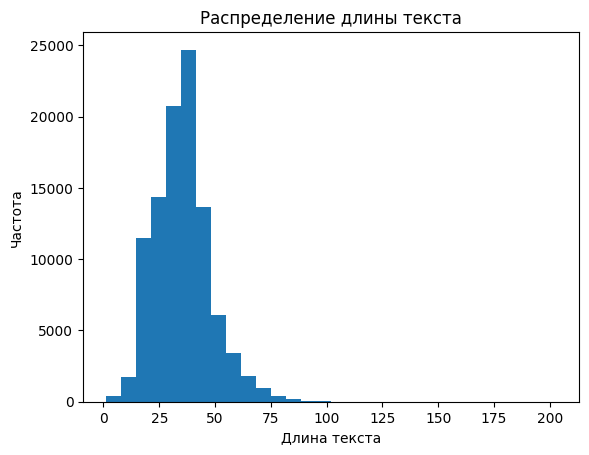

Средняя длина текста: 35.25795


In [64]:
# Длина текста train
text_lengths_tr = [len(item['text']) for item in train_ds]

# Гистограмма длины текста
plt.hist(text_lengths_tr, bins=30)
plt.title('Распределение длины текста')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

# Средняя длина текста
print(f"Средняя длина текста: {sum(text_lengths_tr) / len(text_lengths_tr)}")

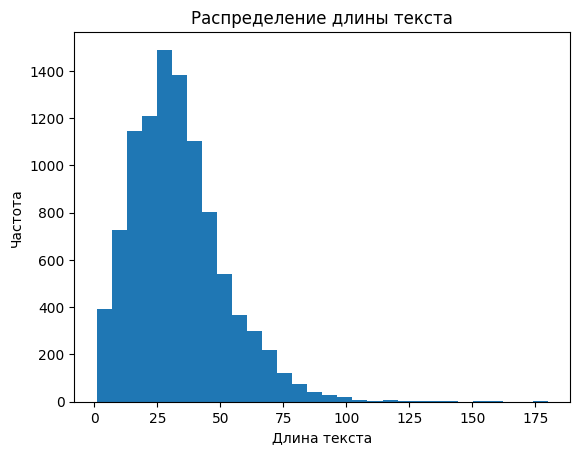

Средняя длина текста: 33.02001200720432


In [65]:
# Длина текста теста
text_lengths_ts = [len(item['text']) for item in validation_ds]

# Гистограмма длины текста
plt.hist(text_lengths_ts, bins=30)
plt.title('Распределение длины текста')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.show()

# Средняя длина текста
print(f"Средняя длина текста: {sum(text_lengths_ts) / len(text_lengths_ts)}")

4. Анализ длительности аудио

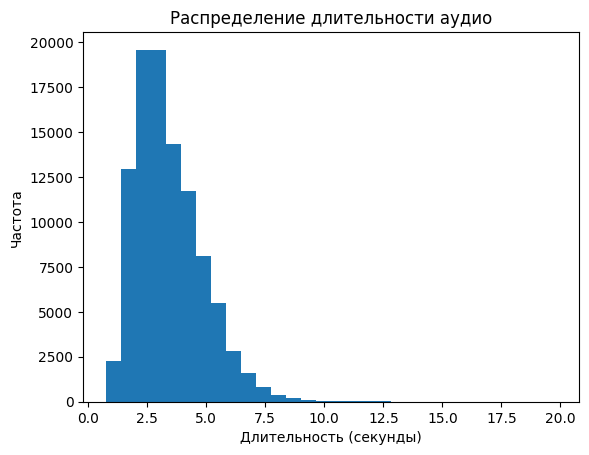

Средняя длительность аудио в секунда: 3.40977420125


In [66]:
# Длительность аудио train
durations_tr = [item['duration'] for item in train_ds]

# Гистограмма длительности аудио
plt.hist(durations_tr, bins=30)
plt.title('Распределение длительности аудио')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Частота')
plt.show()

# Средняя длительность аудио
print(f"Средняя длительность аудио в секунда: {sum(durations_tr) / len(durations_tr)}")

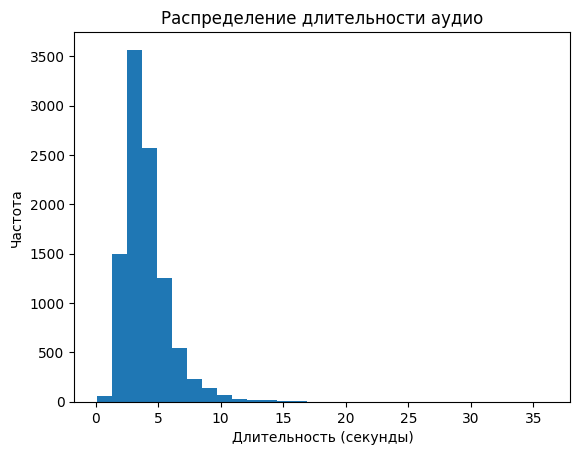

Средняя длительность аудио в секундах: 4.0345401115669395


In [67]:
# Длительность аудио теста
durations_ts = [item['duration'] for item in validation_ds]

# Гистограмма длительности аудио
plt.hist(durations_ts, bins=30)
plt.title('Распределение длительности аудио')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Частота')
plt.show()

# Средняя длительность аудио
print(f"Средняя длительность аудио в секундах: {sum(durations_ts) / len(durations_ts)}")

5. Анализ уникальных значений

In [68]:
# Уникальных значений в train
unique_texts = set(item['text'] for item in train_ds)
print(f"Количество уникальных текстов: {len(unique_texts)}")

Количество уникальных текстов: 55611


In [69]:
# Уникальных значений в тест
unique_texts = set(item['text'] for item in validation_ds)
print(f"Количество уникальных текстов: {len(unique_texts)}")

Количество уникальных текстов: 9637


6. Анализ пропущенных значений

In [70]:
# пропущенных значений в train
for key in train_ds.features:
    missing_values = sum(1 for item in train_ds if item[key] is None)
    print(f"Пропущенные значения в '{key}': {missing_values}")

Пропущенные значения в 'id': 0
Пропущенные значения в 'audio_filepath': 0
Пропущенные значения в 'text': 0
Пропущенные значения в 'duration': 0


In [71]:
# пропущенных значений в тест
for key in validation_ds.features:
    missing_values = sum(1 for item in train_ds if item[key] is None)
    print(f"Пропущенные значения в '{key}': {missing_values}")

Пропущенные значения в 'id': 0
Пропущенные значения в 'audio_filepath': 0
Пропущенные значения в 'text': 0
Пропущенные значения в 'duration': 0


7. Самые частые тексты

In [72]:
# Самые частые тексты в train
# Частота текстов
text_counter_tr = Counter(item['text'] for item in train_ds)

# Самые частые тексты
print("Самые частые тексты:")
print(text_counter_tr.most_common(10))

# Самые редкие тексты
print("Самые редкие тексты:")
print(text_counter_tr.most_common()[-10:])

Самые частые тексты:
[('включи первый канал', 253), ('включи тнт', 116), ('включи стс', 104), ('радость моя на смотрешке', 102), ('охота и рыбалка на смотрешке', 101), ('мир на смотрешке', 97), ('е на смотрешке', 70), ('стс на смотрешке', 70), ('рыжий на смотрешке', 70), ('еврокино на смотрешке', 69)]
Самые редкие тексты:
[('открой мне передачу м один глобал на тв', 1), ('загрузи на телевизоре авто плюс', 1), ('покажи мне канал фэшн на ти ви', 1), ('телеканал мир сериала', 1), ('покажи на тв пятница', 1), ('включи канал точка на телевизоре', 1), ('врубай на тв ртд', 1), ('найди на тв канал кинокомедия', 1), ('включи канал парамаунт камеди на тв', 1), ('поищи открытый мир на телевизоре', 1)]


In [73]:
# Самые частые тексты в тест
# Частота текстов
text_counter_ts = Counter(item['text'] for item in validation_ds)

# Самые частые тексты
print("Самые частые тексты:")
print(text_counter_ts.most_common(10))

# Самые редкие тексты
print("Самые редкие тексты:")
print(text_counter_ts.most_common()[-10:])

Самые частые тексты:
[(' ', 98), ('выключи', 12), ('ок ок', 8), ('подключи', 8), ('фильм', 7), ('агат', 7), ('ок', 6), ('инн', 6), ('включи фильм нимани', 6), ('из панка', 6)]
Самые редкие тексты:
[('включи канал украина', 1), ('вруби шулера', 1), ('центральный рынок', 1), ('привет алиса у меня дома закончились баклажаны пожалуйста доставь мне их на дом по моему адресу', 1), ('посоветуй мне шестая часть как избежать наказания за убийство', 1), ('сбер здравствуйте как оплатить номер телефона бонусами', 1), ('рудню', 1), ('найти мульт щенячий патруль', 1), ('стол из эпоксидной смолы', 1), ('шесть четыреста семьдесят шесть четыреста двадцать ноль восемнадцать восемьдесят семь', 1)]


8. Визуализация данных

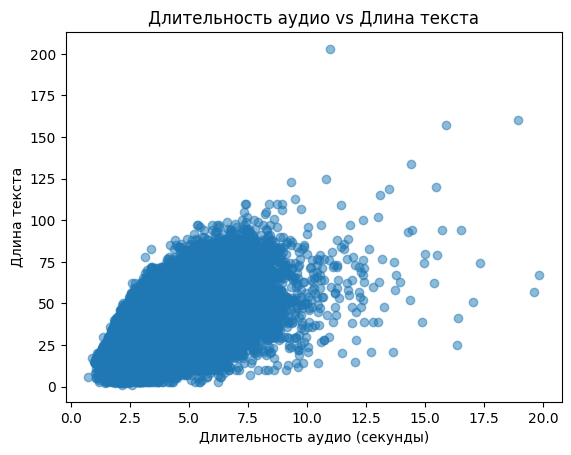

In [75]:
# Визуализация данных в train
plt.scatter(durations_tr, text_lengths_tr, alpha=0.5)
plt.title('Длительность аудио vs Длина текста')
plt.xlabel('Длительность аудио (секунды)')
plt.ylabel('Длина текста')
plt.show()

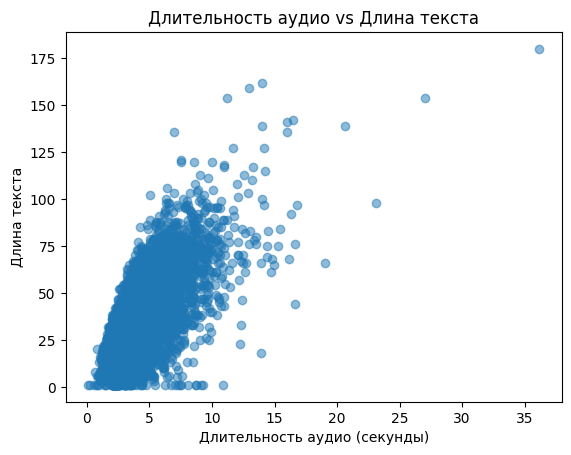

In [77]:
# Визуализация данных в тест
plt.scatter(durations_ts, text_lengths_ts, alpha=0.5)
plt.title('Длительность аудио vs Длина текста')
plt.xlabel('Длительность аудио (секунды)')
plt.ylabel('Длина текста')
plt.show()

Диапазоны значений:

Длительность аудио: от 0.0 до 20.0 секунд.

Длина текста: от 0 до 200.

Большинство точек сосредоточено в области 5–10 секунд и 50–100.

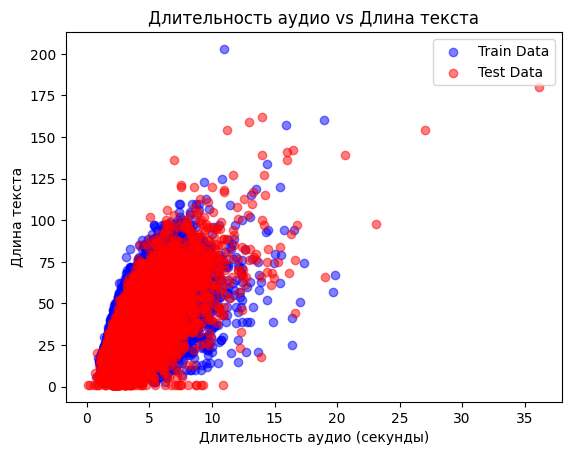

In [78]:
import matplotlib.pyplot as plt

# Визуализация данных на одном графике
plt.scatter(durations_tr, text_lengths_tr, alpha=0.5, color='blue', label='Train Data')  # Тренировочные данные (синий)
plt.scatter(durations_ts, text_lengths_ts, alpha=0.5, color='red', label='Test Data')   # Тестовые данные (красный)

# Настройка графика
plt.title('Длительность аудио vs Длина текста')
plt.xlabel('Длительность аудио (секунды)')
plt.ylabel('Длина текста')
plt.legend()  # Добавляем легенду
plt.show()

Большая часть trani и тесть имеет общее распределение.

Проведем анализ уникальных слов в train и тест:

In [87]:
"""
Извлекает уникальные слова из заданного набора данных.

Функция принимает набор данных и возвращает множество уникальных слов, 
содержащихся в текстовых данных.

Args:
    dataset (iterable): Набор данных, состоящий из объектов, содержащих текст в поле 'text'.

Returns:
    set: Множество уникальных слов, найденных в тексте из заданного набора данных.

Примечание:
    Функция разбивает каждую текстовую строку на слова, используя пробелы в качестве разделителей.
    Она использует множество для автоматического исключения дубликатов.
"""
# Уникальные слова в train_ds
unique_words_tr = get_unique_words(train_ds)

# Уникальные слова в validation_ds
unique_words_ts = get_unique_words(validation_ds)

# Функция для извлечения уникальных слов
def get_unique_words(dataset):
    words = set()
    for item in dataset:
        text = item['text']
        words.update(text.split())  # Разбиваем текст на слова и добавляем в множество
    return words

# Уникальные слова в train_ds
unique_words_tr = get_unique_words(train_ds)

# Уникальные слова в validation_ds
unique_words_ts = get_unique_words(validation_ds)

In [88]:
# Слова, которые есть в train_ds, но отсутствуют в validation_ds
diff_tr = unique_words_tr - unique_words_ts

# Слова, которые есть в validation_ds, но отсутствуют в train_ds
diff_ts = unique_words_ts - unique_words_tr

print(f"Слова, уникальные для train_ds: {len(diff_tr)}")
print(f"Слова, уникальные для validation_ds: {len(diff_ts)}")

Слова, уникальные для train_ds: 2801
Слова, уникальные для validation_ds: 8661


Общее количество уникальных слов: 14104
Процент уникальных слов, отсутствующих в train_ds: 61.41%
Процент уникальных слов, отсутствующих в validation_ds: 19.86%

Уникальные слова, отсутствующие в train_ds:
{'шатровом', 'помело', 'одиночку', 'сумасшедший', 'аэсэмэр', 'плюнуть', 'индира', 'подвижной', 'твою', 'эльдорадо', 'коммент', 'честь', 'состоишь', 'олейна', 'краснодарский', 'бумер', 'чернигов', 'развлечений', 'оуэн', 'аномалия', 'мега', 'уксуса', 'чужак', 'малинин', 'шампанского', 'соню', 'неприятности', 'супа', 'медок', 'бонусную', 'английском', 'ходячий', 'княжество', 'мех', 'приповерхностный', 'парка', 'лежит', 'трекинговые', 'заблудившегося', 'случаев', 'старой', 'жекич', 'бухгалтерия', 'одуванчик', 'цеппелин', 'киллерс', 'ирландии', 'тревога', 'взрывная', 'перерождение', 'скверный', 'мартюк', 'сигареты', 'вениаминович', 'жители', 'врач', 'дава', 'вина', 'мираторг', 'попьюла', 'чернявского', 'жестокости', 'вегаса', 'нико', 'семи', 'гайдай', 'лир', 'майсур', 'турбофорсаж', 'инсп

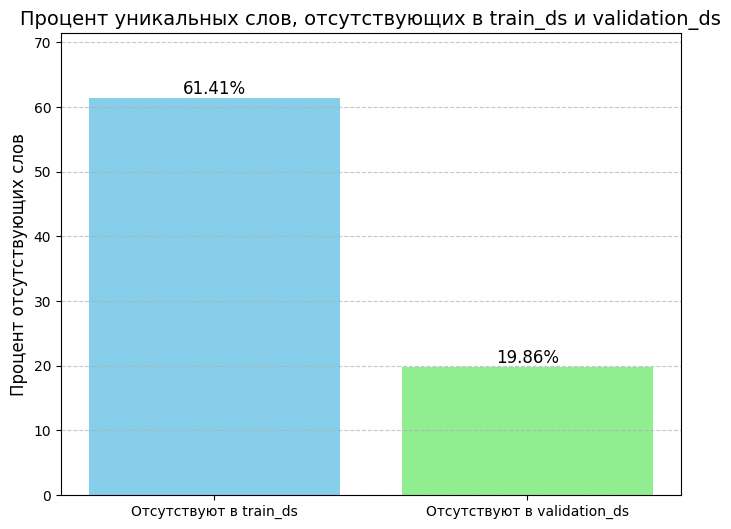

In [93]:
"""
Извлекает все слова из тренировочного и валидационного наборов данных, 
вычисляет их уникальные значения и анализирует различия.

Функция выполняет следующие действия:
1. Извлекает все слова из заданного набора данных.
2. Объединяет все извлеченные слова из тренировочного и валидационного наборов.
3. Получает уникальные слова из объединенного списка.
4. Вычисляет общее количество уникальных слов.
5. Определяет уникальные слова, отсутствующие в каждом наборе.
6. Вычисляет процент уникальных слов, отсутствующих в тренировочном и валидационном наборах.

Args:
    train_ds (iterable): Тренировочный набор данных, состоящий из объектов с полем 'text'.
    validation_ds (iterable): Валидационный набор данных, состоящий из объектов с полем 'text'.

Returns:
    None: Результаты выводятся в консоль.

Примечание:
    Уникальные слова извлекаются путем разделения текста на слова по пробелам,
    и используется множество для автоматического исключения дубликатов.
"""
# Функция для извлечения всех слов из датасета
def get_all_words(dataset):
    words = []
    for item in dataset:
        text = item['text']
        words.extend(text.split())  # Разбиваем текст на слова и добавляем в список
    return words

# Получаем все слова из train_ds и validation_ds
all_words_train = get_all_words(train_ds)
all_words_validation = get_all_words(validation_ds)

# Объединяем все слова в один список
all_words = all_words_train + all_words_validation

# Получаем уникальные слова из объединенного списка
unique_words = set(all_words)

# Количество уникальных слов
total_unique_words = len(unique_words)
print(f"Общее количество уникальных слов: {total_unique_words}")

# Находим уникальные слова, отсутствующие в train_ds
missing_in_train = unique_words - set(all_words_train)

# Находим уникальные слова, отсутствующие в validation_ds
missing_in_validation = unique_words - set(all_words_validation)

# Процент уникальных слов, отсутствующих в train_ds
percent_missing_train = (len(missing_in_train) / total_unique_words) * 100
print(f"Процент уникальных слов, отсутствующих в train_ds: {percent_missing_train:.2f}%")

# Процент уникальных слов, отсутствующих в validation_ds
percent_missing_validation = (len(missing_in_validation) / total_unique_words) * 100
print(f"Процент уникальных слов, отсутствующих в validation_ds: {percent_missing_validation:.2f}%")

# Вывод уникальных слов, отсутствующих в train_ds
print("\nУникальные слова, отсутствующие в train_ds:")
print(missing_in_train)

# Вывод уникальных слов, отсутствующих в validation_ds
print("\nУникальные слова, отсутствующие в validation_ds:")
print(missing_in_validation)

# Визуализация результатов
labels = ['Отсутствуют в train_ds', 'Отсутствуют в validation_ds']
percentages = [percent_missing_train, percent_missing_validation]

# Создаем столбчатую диаграмму
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, percentages, color=['skyblue', 'lightgreen'])

# Добавляем текстовые аннотации с процентами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12)

# Настройка графика
plt.title('Процент уникальных слов, отсутствующих в train_ds и validation_ds', fontsize=14)
plt.ylabel('Процент отсутствующих слов', fontsize=12)
plt.ylim(0, max(percentages) + 10)  # Добавляем небольшой отступ сверху
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показываем график
plt.show()

Высокий процент уникальных слов, отсутствующих в train_ds (61.41%)

Эффект на обучение:
- Модель не будет обучена на 61.41% уникальных слов, которые присутствуют в валидационном наборе или в объединенном наборе данных. Это может привести к тому, что модель не сможет корректно обрабатывать эти слова во время валидации или тестирования.
- Возможное ухудшение обобщающей способности модели, так как она не знакома с большим количеством слов, которые могут встречаться в реальных данных.

Низкий процент уникальных слов, отсутствующих в validation_ds (19.86%)

Эффект на валидацию:
- Модель будет знакома с большинством слов в валидационном наборе (80.14%), что позволяет более точно оценить её производительность.
- Однако 19.86% отсутствующих слов могут указывать на недостаточное разнообразие валидационного набора, что может привести к завышенной оценке качества модели.

9. Анализ аудиофайлов

In [ ]:
# Анализа одного аудиофайла
audio_path = train_ds[0]['audio_filepath']
y, sr = librosa.load(audio_path, sr=None)
print(f"Частота дискретизации: {sr} Hz")
print(f"Количество каналов: {y.shape}")

Частота дискретизации: 16000 Hz
Количество каналов: (19360,)


Частота дискретизации (sr): 16000 Hz:
- Это означает, что аудиофайл был записан с частотой 16000 измерений (сэмплов) в секунду. Это стандартная частота для задач обработки речи.
- Количество каналов: (19360,):
- Форма массива y — (19360,). Это означает, что аудиофайл содержит 19360 сэмплов и имеет 1 канал (моно).

Оценим длительность записей в train

In [94]:
# Извлекаем длительности всех записей
durations = train_ds["duration"]

# Суммируем длительности
total_duration = np.sum(durations)

# Выводим общую длительность
print(f"Общая длительность аудиозаписей: {total_duration} секунд")

Общая длительность аудиозаписей: 340977.420125 секунд


In [12]:
# Переводим секунды в минуты и часы
total_duration_minutes = total_duration / 60
total_duration_hours = total_duration_minutes / 60

print(f"Общая длительность аудиозаписей: {total_duration} секунд, {total_duration_minutes:.2f} минут, {total_duration_hours:.2f} часов")

Общая длительность аудиозаписей: 340977.420125 секунд, 5682.96 минут, 94.72 часов


## Загрузка модели

In [50]:
"""
Конфигурация для предобработки данных и подготовки к дообучению модели Whisper.

Код выполняет следующие шаги:
1. Настраивает логирование с уровнем информации через модуль `logging`.
2. Определяет пути к директориям для наборов данных и выходным результатам.
3. Формирует пути к манифестам для обучающего и валидационного наборов данных, основанные на заданной директории.
4. Загружает обучающий и валидационный наборы данных из файлов JSON с использованием функции `load_dataset`.
5. Определяет устройство для выполнения модели (GPU, если доступно, иначе CPU).
6. Загружает токенизатор, извлекатель признаков и процессор для модели Whisper с установленными параметрами.

Variables:
    - `dataset_dir` (str): Директория, содержащая наборы данных для обучения.
    - `output_dir` (str): Директория для сохранения результатов дообучения.
    - `train_manifest_path` (str): Путь к файлу манифеста для обучающего набора данных.
    - `validation_manifest_path` (str): Путь к файлу манифеста для валидационного набора данных.
    - `processed_data_dir` (str): Директория для сохраненных обработанных данных.
    - `device` (torch.device): Устройство, на котором будет выполняться модель (CUDA или CPU).
    - `tokenizer` (WhisperTokenizer): Токенизатор для обработки текстовых данных.
    - `feature_extractor` (WhisperFeatureExtractor): Извлекатель признаков для обработки аудиоданных.
    - `processor` (WhisperProcessor): Объект для объединения токенизатора и извлекателя признаков.

Returns:
    None. Все данные и конфигурации подготавливаются для последующего использования в дообучении модели.
"""
# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

dataset_dir="/workspace/diplom/dataset"
output_dir="/workspace/diplom/whisper-finetuned"

# Пути к файлам и директориям
# Без пунктуации
train_manifest_path = os.path.join(dataset_dir, "train/train_manifest.jsonl")# dataset без понктуации
validation_manifest_path = os.path.join(dataset_dir, "test/crowd/validation_manifest.jsonl") # dataset без понктуации
processed_data_dir = os.path.join(dataset_dir, "save")

# Загрузка train и validation данных
train_ds = load_dataset('json', data_files=train_manifest_path, split='train')
validation_ds = load_dataset('json', data_files=validation_manifest_path, split='train')

# Определение устройства (GPU, если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка модели и токенизатора и feature_extractor
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Russian", task="transcribe")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Russian", task="transcribe")

## Подготовка данных для модели:

In [ ]:
"""
Обработка и подготовка аудиоданных для обучающего и валидационного наборов данных.

Код выполняет следующие шаги:
1. Приводит аудио файлы к частоте дискретизации 16 кГц.
2. Определяет функцию `prepare_dataset`, которая:
   - Извлекает аудио и его частоту дискретизации.
   - Вычисляет признаки аудио с использованием `feature_extractor`.
   - Токенизирует текстовые метки с использованием `tokenizer`.
3. Применяет функцию `prepare_dataset` к обучающему и валидационному наборам данных, удаляя ненужные колонки.
4. Сохраняет обработанные наборы данных на диск.

Аргументы:
    - `train_ds`: Обучающий набор данных, который будет обработан.
    - `validation_ds`: Валидационный набор данных, который будет обработан.
    - `feature_extractor`: Объект для извлечения признаков аудио.
    - `tokenizer`: Объект для токенизации текстовых меток.
    - `processed_data_dir`: Путь к директории, где будут сохранены обработанные данные.

Возвращает:
    None. Обработанные наборы данных сохраняются на диск.
"""

# Приведение аудио к частоте дискретизации 16 кГц
train_ds = train_ds.cast_column("audio_filepath", Audio(sampling_rate=16000))
validation_ds = validation_ds.cast_column("audio_filepath", Audio(sampling_rate=16000))

# Функция для предобработки данных
def prepare_dataset(batch):
    # Извлекаем аудио и частоту дискретизации
    audio = batch["audio_filepath"]
    
    # Извлекаем признаки (input_features)
    batch["input_features"] = feature_extractor(
        audio["array"], 
        sampling_rate=audio["sampling_rate"]
    ).input_features[0]
    
    # Токенизируем текст (labels)
    batch["labels"] = tokenizer(batch["text"]).input_ids
    return batch

# Применяем функцию к датасету и удаляем ненужные колонки
train_ds = train_ds.map(prepare_dataset, remove_columns=["audio_filepath", "id", "duration"],num_proc = 1)
validation_ds = validation_ds.map(prepare_dataset, remove_columns=["audio_filepath", "id", "duration"], num_proc = 1)

#Сохранение обработанных данных
train_ds.save_to_disk(os.path.join(processed_data_dir, "train_ds"))
validation_ds.save_to_disk(os.path.join(processed_data_dir, "validation_ds"))

## Загрузка сохраненных данных:

In [14]:
"""
Загрузка сохраненных наборов данных для обучения и валидации.

Код выполняет несколько шагов:
1. Загружает заранее сохраненные данные для обучающего набора и валидационного набора из указанных директорий.
2. Использует метод `load_from_disk` из библиотеки `datasets` для восстановления объектов наборов данных из файловой системы.

Variables:
    - `train_dsf` (Dataset): Объект набора данных для обучения, загруженный из директории, где находятся обработанные данные.
    - `validation_dsf` (Dataset): Объект набора данных для валидации, загруженный из директории, где находятся обработанные данные.

Returns:
    None. Загруженные наборы данных сохраняются в переменные для последующего использования в процессе обучения и оценки модели.
"""
# Загрузка сохраненных данных
train_dsf = Dataset.load_from_disk(os.path.join(processed_data_dir, "train_ds"))
validation_dsf = Dataset.load_from_disk(os.path.join(processed_data_dir, "validation_ds"))

Loading dataset from disk:   0%|          | 0/193 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/20 [00:00<?, ?it/s]

Посмотрим на внесенные изменения в train_dsf

In [19]:
"""
Получение первого элемента из обучающего набора данных.

Код выполняет доступ к первому примеру в загруженном обучающем наборе данных `train_dsf`.

Returns:
    - `train_dsf[0]`: dict или другой тип данных, представляющий первый элемент набора данных.
    Содержит данные, такие как входные аудиофайлы и соответствующие метки или текстовые транскрипции, в зависимости от структуры набора данных.

Примечание:
    Объект `train_dsf` должен быть инициализирован через `Dataset.load_from_disk` для правильного получения данных.
"""
train_dsf[0]

{'text': 'алиби',
 'input_features': [[-0.08352434635162354,
   0.12183904647827148,
   0.008681714534759521,
   0.06785917282104492,
   0.12331467866897583,
   0.024083495140075684,
   0.050675153732299805,
   0.15586334466934204,
   0.1268489956855774,
   0.10877048969268799,
   0.05659043788909912,
   0.07820641994476318,
   0.02711254358291626,
   -0.13631904125213623,
   -0.1938924789428711,
   -0.028215646743774414,
   -0.029709696769714355,
   -0.15294277667999268,
   -0.2439190149307251,
   -0.11400783061981201,
   -0.5176585912704468,
   -0.3891291618347168,
   -0.34694790840148926,
   -0.31819891929626465,
   -0.658576250076294,
   -0.5713187456130981,
   -0.21541881561279297,
   -0.20295286178588867,
   -0.22384905815124512,
   -0.02561187744140625,
   -0.10027897357940674,
   -0.06618261337280273,
   -0.04059314727783203,
   -0.0125504732131958,
   -0.025397062301635742,
   0.02114158868789673,
   -0.04743063449859619,
   -0.12273502349853516,
   -0.08982574939727783,
   -0

Посмотрим на внесенные изменения в validation_dsf

In [20]:
"""
Получение первого элемента из валидационного набора данных.

Код выполняет доступ к первому примеру в загруженном валидационном наборе данных `validation_dsf`.

Returns:
    - `validation_dsf[0]`: dict или другой тип данных, представляющий первый элемент набора данных.
    Содержит данные, такие как входные аудиофайлы и соответствующие метки или текстовые транскрипции, в зависимости от структуры набора данных.

Примечание:
    Объект `validation_dsf` должен быть инициализирован через `Dataset.load_from_disk` для правильного получения данных.
"""
validation_dsf[0]

{'text': 'афина воспроизведи музыку вперемешку',
 'input_features': [[0.14019739627838135,
   0.64002525806427,
   0.6202026605606079,
   0.5421344637870789,
   0.40771961212158203,
   0.24619215726852417,
   0.3808841109275818,
   0.490039587020874,
   0.5579701662063599,
   0.6060128808021545,
   0.6363636255264282,
   0.6421108841896057,
   0.6434441804885864,
   0.6362711787223816,
   0.6266360878944397,
   0.6212411522865295,
   0.6129454970359802,
   0.5977100729942322,
   0.5910462141036987,
   0.5746749639511108,
   0.5644652247428894,
   0.5487145185470581,
   0.5385128259658813,
   0.523922860622406,
   0.5019805431365967,
   0.49632489681243896,
   0.4836793541908264,
   0.46517956256866455,
   0.4508461356163025,
   0.43304741382598877,
   0.42462342977523804,
   0.4054313898086548,
   0.39826053380966187,
   0.38921546936035156,
   0.36857670545578003,
   0.34840744733810425,
   0.3447023034095764,
   0.32718658447265625,
   0.3114720582962036,
   0.30276596546173096,
   0

Визуализируем спектрограмму первая запись в train_dsf

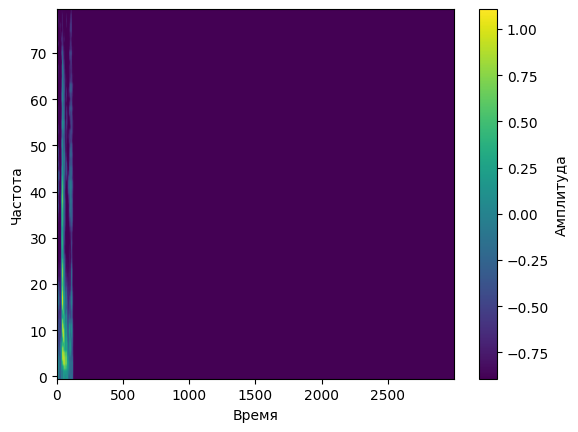

In [25]:
"""
Отображение спектрограммы или других входных признаков из тестового датасета.

Код выполняет следующие шаги:
1. Извлекает первую запись из тренировочного набора данных `train_dsf`.
2. Отображает входные признаки в виде спектрограммы с использованием библиотеки Matplotlib.
3. Настраивает подписи для осей и добавляет цветовую шкалу для обозначения амплитуды.

Returns:
    None. График отображается с помощью `plt.show()`.

Примечание:
    Убедитесь, что выборка из `train_dsf` содержит входные признаки с ключом 'input_features'. 
    Если используется другой набор данных или структура, необходимо корректировать ключи, используемые в коде.
"""

# Выберите одну запись из тестового датасета
exampleT = train_dsf[0]  # Первая запись в датасете

# Отображение спектрограммы или других входных признаков
plt.imshow(exampleT['input_features'], aspect='auto', origin='lower')

# Подписи осей
plt.xlabel('Время')  # Ось X: Время
plt.ylabel('Частота')  # Ось Y: Частота

# Цветовая шкала (colorbar) с подписью
plt.colorbar(label='Амплитуда')  # Шкала амплитуды

# Показать график
plt.show()

Визуализируем спектрограмму первая запись в validation_dsf

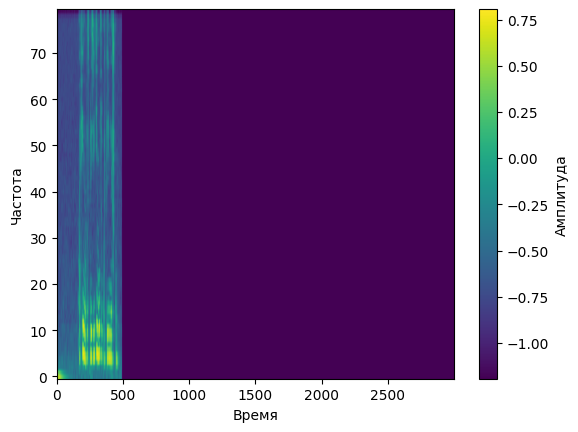

In [26]:
"""
Отображение спектрограммы или других входных признаков из валидационного датасета.

Код выполняет следующие шаги:
1. Извлекает первую запись из валидационного набора данных `validation_dsf`.
2. Отображает входные признаки в виде спектрограммы с использованием библиотеки Matplotlib.
3. Настраивает подписи для осей и добавляет цветовую шкалу для обозначения амплитуды.

Returns:
    None. График отображается с помощью `plt.show()`.

Примечание:
    Убедитесь, что выборка из `validation_dsf` содержит входные признаки с ключом 'input_features'. 
    Если используется другой набор данных или структура, необходимо корректировать ключи, используемые в коде.
"""
# Выберите одну запись из тестового датасета
exampleV = validation_dsf[0]  # Первая запись в датасете

# Отображение спектрограммы или других входных признаков
plt.imshow(exampleV['input_features'], aspect='auto', origin='lower')

# Подписи осей
plt.xlabel('Время')  # Ось X: Время
plt.ylabel('Частота')  # Ось Y: Частота

# Цветовая шкала (colorbar) с подписью
plt.colorbar(label='Амплитуда')  # Шкала амплитуды

# Показать график
plt.show()

# Поиск оптимальных гиперпараметров

Основная цель кода — оптимизировать гиперпараметры модели с помощью библиотеки Optuna для минимизации метрики WER (Word Error Rate) — метрики, которая измеряет качество распознавания речи.

In [ ]:

"""
Скрипт для обучения и оптимизации модели Whisper для распознавания русской речи.

Этот скрипт выполняет следующие основные задачи:
1. Настраивает логирование и определяет устройство для выполнения (GPU/CPU)
2. Загружает предобученную модель Whisper, токенизатор и feature extractor
3. Реализует data collator для обработки речевых данных
4. Настраивает метрики оценки качества (WER)
5. Выполняет оптимизацию гиперпараметров с помощью Optuna

Основные компоненты:
- DataCollatorSpeechSeq2SeqWithPadding: класс для батчирования и паддинга данных
- compute_metrics: функция для вычисления метрики WER
- objective: функция оптимизации гиперпараметров для Optuna

Гиперпараметры для оптимизации:
- learning_rate: скорость обучения (1e-6 до 1e-4)
- batch_size: размер батча (фиксирован на 32)
- warmup_steps: шаги разогрева (50-500)
- gradient_accumulation_steps: шаги накопления градиента (1-4)

Требования:
- PyTorch
- Transformers
- Datasets
- Evaluate
- Optuna
- Logging

Результаты:
- Сохраняет лучшую модель и логи в указанную директорию
- Выводит лучшие найденные гиперпараметры и значение WER

Примечание:
Предполагается, что train_dsf и validation_dsf уже определены и содержат
соответствующие наборы данных для обучения и валидации.
"""

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Определение устройства (GPU, если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Используемое устройство: {device}")

# Загрузка модели и токенизатора
logger.info("Загрузка токенизатора и feature extractor...")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Russian", task="transcribe")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Russian", task="transcribe")
logger.info("Токенизатор и feature extractor успешно загружены.")

# Data Collator
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Класс для батчирования и паддинга данных для задач распознавания речи.

    Этот класс отвечает за преобразование списка признаков речи в батч с паддингом,
    подходящий для использования в модели Seq2Seq. Он использует обработчик данных
    (например, токенизатор и извлекатель признаков) для подготовки входных данных и меток.

    Атрибуты:
        processor (Any): Объект, содержащий инструменты для извлечения признаков и токенизации данных.

    Методы:
        call(features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
            Принимает список признаков и возвращает батч с подгруппами данных,
            включая входные данные (input_features) и метки (labels), с применением паддинга.
            
    Параметры:
        features: Список словарей, каждый из которых содержит ключи:
            - "input_features": Список или тензор, представляющий входные данные для модели.
            - "labels": Список идентификаторов токенов, представляющих соответствующие целевые данные.

    Возвращает:
        Dict[str, torch.Tensor]: Словарь, содержащий тензоры для входных данных и меток,
        готовые для передачи в модель.
    """
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)
logger.info("Data collator успешно создан.")

# Загрузка метрики WER
metric = evaluate.load("wer")
logger.info("Метрика WER успешно загружена.")

def compute_metrics(pred):
    """
    Вычисляет метрики качества для предсказаний модели распознавания речи.

    Эта функция принимает объект с предсказаниями и эталонными метками, декодирует их,
    фильтрует пустые строки и вычисляет метрику WER (Word Error Rate).

    Параметры:
        pred: Объект, содержащий предсказания и метки, с атрибутами:
            - predictions: Предсказанные идентификаторы токенов (np.ndarray или torch.Tensor).
            - label_ids: Эталонные идентификаторы токенов (np.ndarray или torch.Tensor).

    Возвращает:
        Dict[str, float]: Словарь, содержащий значение WER, где ключ - "wer".

    Логирование:
        - Функция логирует первые 15 отфильтрованных предсказаний и меток.
        - Если нет отфильтрованных примеров, выводится предупреждение и возвращается WER равный 0.
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Заменяем -100 на pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Декодируем предсказания и метки
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Фильтруем пустые метки
    filtered = [(p, l) for p, l in zip(pred_str, label_str) if l.strip()]
    if not filtered:
        logger.warning("Нет отфильтрованных примеров для логирования.")
        return {"wer": 0.0}

    pred_filtered, label_filtered = zip(*filtered)

    # Логируем первые несколько предсказаний и меток
    for i in range(min(15, len(pred_filtered))):
        logger.info(f"Отфильтрованное предсказание: {pred_filtered[i]}")
        logger.info(f"Отфильтрованная эталонная метка: {label_filtered[i]}")

    # Вычисляем WER
    wer = 100 * metric.compute(predictions=pred_filtered, references=label_filtered)
    logger.info(f"WER: {wer}")
    return {"wer": wer}

# Настройка модели
logger.info("Загрузка модели WhisperForConditionalGeneration...")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

model.to(device)
logger.info("Модель успешно загружена и настроена.")

"""
Настройка конфигурации модели для декодирования.

Эти строчки кода изменяют параметры конфигурации модели, связанные с декодированием:

1. model.config.forced_decoder_ids = None:
   Устанавливает значение forced_decoder_ids в None, что означает,
   что модель не будет использовать предопределенные идентификаторы токенов
   при декодировании. Это позволяет модели самостоятельно генерировать последовательности
   токенов без каких-либо принудительных ограничений.

2. model.config.suppress_tokens = []:
   Устанавливает список suppress_tokens как пустой. Это означает, что
   во время генерации последовательности модель не будет подавлять (не будет
   исключать) никаких токенов, что позволяет ей генерировать полный
   диапазон возможных токенов.

Эти настройки могут быть полезны для достижения более гибких результатов
генерации текста без жестких ограничений со стороны модели.
"""
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []


# Функция для оптимизации гиперпараметров
def objective(trial):
    """
    Функция оптимизации гиперпараметров для обучения модели Whisper с использованием Optuna.
    
    Оптимизирует следующие гиперпараметры:
    - learning_rate: скорость обучения (float, от 1e-6 до 1e-4)
    - batch_size: размер батча (фиксированный, 32)
    - warmup_steps: количество шагов разогрева (int, от 50 до 500)
    - gradient_accumulation_steps: шаги накопления градиента (int, от 1 до 4)
    
    Args:
        trial (optuna.Trial): Объект trial для предложения гиперпараметров
        
    Returns:
        float: Значение метрики WER (Word Error Rate) на валидационном наборе
        
    Процесс:
    1. Генерирует гиперпараметры с помощью trial
    2. Создает уникальную директорию для текущей попытки
    3. Настраивает аргументы обучения (Seq2SeqTrainingArguments)
    4. Инициализирует оптимизатор AdamW
    5. Создает и настраивает Seq2SeqTrainer
    6. Проводит обучение модели
    7. Оценивает модель на валидационном наборе
    
    Note:
        - Использует раннюю остановку с терпением 3 эпохи
        - Сохраняет чекпоинты каждые 300 шагов
        - Проводит оценку каждые 100 шагов
        - Использует линейный планировщик скорости обучения
    """
    # Предлагаемые гиперпараметры
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32])
    warmup_steps = trial.suggest_int("warmup_steps", 50, 500, step=50)
    gradient_accumulation_steps = trial.suggest_int("gradient_accumulation_steps", 1, 4)

    logger.info(f"Пробуем гиперпараметры: learning_rate={learning_rate}, batch_size={batch_size}, warmup_steps={warmup_steps}, gradient_accumulation_steps={gradient_accumulation_steps}")

    # Создаем уникальную директорию для текущего trial
    trial_dir = f"/workspace/diplom/my_whisper/trial_{trial.number}"
    os.makedirs(trial_dir, exist_ok=True)
    logger.info(f"Создана директория для trial {trial.number}: {trial_dir}")

# Настройка аргументов обучения
    """
    Аргументы обучения для модели последовательного кода.

    Этот объект содержит параметры, необходимые для настройки процесса обучения модели, включая параметры оптимизации, стратегии тренировки и настройки логирования.

    Параметры:
    - output_dir (str): Уникальная директория для сохранения результатов обучения и чекпоинтов.
    - per_device_train_batch_size (int): Размер батча для обучения на каждом устройстве (GPU/TPU).
    - per_device_eval_batch_size (int): Размер батча для оценки на каждом устройстве (GPU/TPU).
    - dataloader_num_workers (int): Количество процессов для загрузки данных.
    - learning_rate (float): Скорость обучения, используемая оптимизатором.
    - warmup_steps (int): Количество шагов разогрева для регулировки скорости обучения.
    - max_steps (int): Максимальное количество шагов обучения.
    - gradient_checkpointing (bool): Включает градиентный чекпойнтинг для экономии памяти.
    - fp16 (bool): Использует полупоточность для ускорения обучения и экономии памяти.
    - evaluation_strategy (str): Стратегия оценки модели (“steps” для оценки через определенные шаги).
    - save_steps (int): Каждые сколько шагов сохранять модель.
    - eval_steps (int): Каждые сколько шагов проводить оценку модели.
    - optim (str): Тип оптимизатора для использования (например, "adamw_torch").
    - predict_with_generate (bool): Использовать ли генерацию последовательности при предсказании.
    - generation_max_length (int): Максимальная длина генерируемой последовательности.
    - logging_steps (int): Каждые сколько шагов вести логирование.
    - report_to (list): Стратегия отчетности (например, ["tensorboard"] для отчетов в TensorBoard).
    - load_best_model_at_end (bool): Загружать ли лучшую модель в конце обучения.
    - metric_for_best_model (str): Метрика, по которой будет определяться лучшая модель ("wer").
    - greater_is_better (bool): Определяет, является ли большее значение метрики лучше (False для WER).
    - push_to_hub (bool): Отправлять ли модель в репозиторий Hugging Face Hub.
    - save_total_limit (int): Максимальное количество сохраняемых чекпоинтов.
    - save_safetensors (bool): Сохранять ли модели в формате 'safetensors'.
    - lr_scheduler_type (str): Тип планировщика скорости обучения (например, "linear").
    - seed (int): Начальное значение для генератора случайных чисел.
    - gradient_accumulation_steps (int): Количество шагов для накопления градиента перед обновлением.

    Примечание:
    Этот класс используется для упрощения настройки процесса обучения и позволяет гибко модифицировать его параметры для достижения наилучших результатов.
    """
    training_args = Seq2SeqTrainingArguments(
        output_dir=trial_dir,  # Уникальная директория для каждого trial
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=10,
        dataloader_num_workers=8,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        max_steps=14000,
        gradient_checkpointing=True,
        fp16=True,
        evaluation_strategy="steps",
        save_steps=300,
        eval_steps=100,
        optim="adamw_torch",
        predict_with_generate=True,
        generation_max_length=448,
        logging_steps=25,
        report_to=["tensorboard"],
        load_best_model_at_end=True,
        metric_for_best_model="wer",
        greater_is_better=False,
        push_to_hub=False,
        save_total_limit=30,
        save_safetensors=False,
        lr_scheduler_type="linear",
        seed=42,
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    # Настройка оптимизатора с указанными параметрами
    """
    Оптимизатор AdamW для обучения модели.

    Этот объект предназначен для оптимизации параметров модели во время обучения, используя алгоритм Adam с весовой декомпозицией.

    Параметры:
    - params (iterable): Параметры модели, которые будут оптимизироваться.
    - lr (float): Скорость обучения, используемая для обновления параметров.
    - betas (tuple): Кортеж, содержащий две значения: 
    - beta1 (float): Коэффициент для вычисления экспоненциального скользящего среднего градиента (обычно 0.9).
    - beta2 (float): Коэффициент для вычисления экспоненциального скользящего среднего квадрата градиента (обычно 0.999).
    - eps (float): Малое значение, добавляемое для численной стабильности (обычно 1e-8).
    - weight_decay (float): Размер веса для декомпозиции, используется для уменьшения сложности модели и улучшения обобщающей способности.

    Примечание:
    Оптимизатор AdamW часто используется в задачах глубокого обучения благодаря своей эффективности и способности адаптивно регулировать скорость обучения для каждого параметра.
    """
    optimizer = AdamW(
        model.parameters(),
        lr=training_args.learning_rate,
        betas=(0.9, 0.999),  # betas
        eps=1e-08,  # epsilon
        weight_decay=0.01
    )

    # Создание Trainer
    """
    Создание объекта Seq2SeqTrainer для обучения модели последовательного преобразования.

    Этот класс объединяет все необходимые компоненты для тренировки модели, включая параметры обучения, данные, метрики и дополнительные функции обратного вызова.

    Параметры:
    - args (Seq2SeqTrainingArguments): Аргументы обучения, определяющие настройки процесса тренировки.
    - model (PreTrainedModel): Модель, которую необходимо обучить.
    - train_dataset (Dataset): Набор данных для обучения модели.
    - eval_dataset (Dataset): Набор данных для оценки модели на валидации.
    - data_collator (callable): Функция или объект для объединения образцов данных в батчи.
    - compute_metrics (callable): Функция для вычисления метрик во время оценки, на основе предсказаний и истинных значений.
    - tokenizer (PreTrainedTokenizer): Токенизатор для обработки текстов.
    - optimizers (tuple): Кортеж из двух оптимизаторов, где первый — это основной оптимизатор, а второй (по умолчанию None) — оптимизатор для управления обучением.
    - callbacks (list): Список объектов обратного вызова, которые могут быть использованы для выполнения дополнительных действий во время обучения (например, остановка по раннему останову).

    Примечание:
    Объект Seq2SeqTrainer предоставляет удобный интерфейс для управления процессом обучения, включая автоматическое применение оптимизаторов, обработку метрик, управление чекпоинтами и интеграцию с такими инструментами, как TensorBoard.
    """
    trainer = Seq2SeqTrainer(
        args=training_args,
        model=model,
        train_dataset=train_dsf,
        eval_dataset=validation_dsf,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=processor,
        optimizers=(optimizer, None),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # Обучение модели
    logger.info("Начало обучения модели...")
    trainer.train()
    logger.info("Обучение модели завершено.")

    # Оценка модели на валидационном наборе
    logger.info("Оценка модели на валидационном наборе...")
    eval_results = trainer.evaluate()
    logger.info(f"Результаты оценки: {eval_results}")
    return eval_results["eval_wer"]

# Создание исследования Optuna
study = optuna.create_study(direction="minimize")
logger.info("Исследование Optuna создано.")

# Запуск оптимизации
logger.info("Запуск оптимизации гиперпараметров...")
study.optimize(objective, n_trials=10)
logger.info("Оптимизация завершена.")

# Вывод результатов
logger.info(f"Лучшие гиперпараметры: {study.best_params}")
logger.info(f"Лучшее значение WER: {study.best_value}")

INFO:__main__:Используемое устройство: cuda
INFO:__main__:Загрузка токенизатора и feature extractor...
INFO:__main__:Токенизатор и feature extractor успешно загружены.
INFO:__main__:Data collator успешно создан.
INFO:__main__:Метрика WER успешно загружена.
INFO:__main__:Загрузка модели WhisperForConditionalGeneration...
INFO:__main__:Модель успешно загружена и настроена.
[I 2025-01-15 22:11:40,088] A new study created in memory with name: no-name-bbcdf049-1203-4668-8638-c7a4885a65f8
INFO:__main__:Исследование Optuna создано.
INFO:__main__:Запуск оптимизации гиперпараметров...
INFO:__main__:Пробуем гиперпараметры: learning_rate=1.946971394394227e-06, batch_size=32, warmup_steps=100, gradient_accumulation_steps=2
INFO:__main__:Создана директория для trial 0: /workspace/diplom/my_whisper/trial_0
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_stra

Setting ds_accelerator to cuda (auto detect)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
INFO:__main__:Отфильтрованное предсказание:  व्क्ल्छेत्याख्साना अर्लोवा
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание:  निए उक्लुजे सेजन थ्वा
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание:  ड़े नहोएँज्य मिनिगोल्फ वातेलि
INFO:__main__:Отфильтрованная эталонная метка: где находит

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: не уклюже сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится мини гольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступления по американским
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас введу
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 24.636510500807756
INFO:__main__:Результаты оценки: {'eval_loss': 0.2598327100276947, 'eval_wer': 24.636510500807756, 'eval_runtime': 87.2478, 'eval_samples_per_second': 5.731, 'eval_steps_per_second': 0.573, 'epoch': 0.704}
[I 2025-01-15 23:33:14,462

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: не уклюже сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится мини гольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступления по американским
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас введу
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 24.676898222940228
INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: не уклюже сезон два
INFO:__main__:Отфильтрованная э

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: ньюклюжи сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится мини гольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступления по американским
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас введу
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 24.838449111470112
INFO:__main__:Результаты оценки: {'eval_loss': 0.25423097610473633, 'eval_wer': 24.838449111470112, 'eval_runtime': 70.2736, 'eval_samples_per_second': 7.115, 'eval_steps_per_second': 0.712, 'epoch': 0.768}
[I 2025-01-16 00:42:35,009

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: ньюклюжи сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится мини гольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступления по американским
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас введу
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 24.838449111470112
INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: не уклюже сезон два
INFO:__main__:Отфильтрованная эт

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: не уклюже сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится мини гольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступления по американским
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас введу
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 24.273021001615508
INFO:__main__:Результаты оценки: {'eval_loss': 0.24570907652378082, 'eval_wer': 24.273021001615508, 'eval_runtime': 83.6978, 'eval_samples_per_second': 5.974, 'eval_steps_per_second': 0.597, 'epoch': 0.832}
[I 2025-01-16 02:03:29,54

INFO:__main__:Отфильтрованное предсказание:  Vkličyti aksana ar lovo
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание:  Nu клюži sezon два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: де находится минигольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступление по американским
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас введу
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 54.96768982229402
INFO:__main__:Отфильтрованное предсказание: включить аксана орлов
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание:  мне уклюжая сезон два
INFO:__main__:Отфильтрованная 

INFO:__main__:Отфильтрованное предсказание: включите аксана и орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: ньюклюже сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание:  где находится минигольф лотыль
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпезон десять преступления по американски
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас ведут
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 57.31017770597738
INFO:__main__:Результаты оценки: {'eval_loss': 0.9870964288711548, 'eval_wer': 57.31017770597738, 'eval_runtime': 66.8762, 'eval_samples_per_second': 7.477, 'eval_steps_per_second': 0.748, 'epoch': 0.416}
[I 2025-01-16 02:53:19,310] T

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжия сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: де находится минигольф лотыль
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпезон десять преступления по американски
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас ведю
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 50.88852988691438
INFO:__main__:Отфильтрованное предсказание: включите аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжай сезон два
INFO:__main__:Отфильтрованная эталонн

INFO:__main__:Отфильтрованное предсказание: включите аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжий сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится ми николь фватель
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпезодей сити преступление по американски
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас ведю
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 37.802907915993536
INFO:__main__:Результаты оценки: {'eval_loss': 0.5998631715774536, 'eval_wer': 37.802907915993536, 'eval_runtime': 64.4848, 'eval_samples_per_second': 7.754, 'eval_steps_per_second': 0.775, 'epoch': 0.864}
[I 2025-01-16 04:08:18,156] T

INFO:__main__:Отфильтрованное предсказание: включите аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжий сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится ми николь фватель
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпезодей сити преступление по американски
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас веду
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 37.27786752827141
INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжий сезон два
INFO:__main__:Отфильтрованная этало

INFO:__main__:Отфильтрованное предсказание: включить аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжий сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится минигольф ватель
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпезодесить преступление по американски
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас веду
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 36.187399030694664
INFO:__main__:Результаты оценки: {'eval_loss': 0.5673424005508423, 'eval_wer': 36.187399030694664, 'eval_runtime': 66.8941, 'eval_samples_per_second': 7.475, 'eval_steps_per_second': 0.747, 'epoch': 0.224}
[I 2025-01-16 04:35:01,011] Tria

INFO:__main__:Отфильтрованное предсказание: включи аксана орлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжий сезон два
INFO:__main__:Отфильтрованная эталонная метка: неуклюжая сезон два
INFO:__main__:Отфильтрованное предсказание: где находится минигольф в отеле
INFO:__main__:Отфильтрованная эталонная метка: где находится мини гольф в отеле
INFO:__main__:Отфильтрованное предсказание: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованная эталонная метка: вруби эпизод десять преступление по американски
INFO:__main__:Отфильтрованное предсказание: сейчас ведю
INFO:__main__:Отфильтрованная эталонная метка: сейчас введу
INFO:__main__:WER: 38.08562197092084
INFO:__main__:Отфильтрованное предсказание: включите аксана арлова
INFO:__main__:Отфильтрованная эталонная метка: включить оксана орлова
INFO:__main__:Отфильтрованное предсказание: неуклюжий сезон два
INFO:__main__:Отфильтрованная эталонн

[W 2025-01-16 06:49:26,232] Trial 6 failed with parameters: {'learning_rate': 4.49376795120188e-05, 'batch_size': 32, 'warmup_steps': 150, 'gradient_accumulation_steps': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3206/3245724187.py", line 221, in objective
    trainer.train()
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2052, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2467, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 2915, in _maybe_log_save_evaluate
    met

Персонализировав логи лучшим значением гиперпараметров оказались Trial 2 finished with value: 24.273021001615508 and parameters: {'learning_rate': 1.1996941102422929e-06, 'batch_size': 32, 'warmup_steps': 450, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 24.273021001615508. Но было замечено, что лучшие значения получаются в середине эпохи, после нескольких неудачных попыток было решено понизить значение learning_rate и увеличить gradient_accumulation_steps для аккуратного и постепенного приближения у наилучшим значениям WER.

# Запуск обучения модели с оптимальными гиперпараметрами

In [2]:
"""
Модуль для обучения модели Whisper для распознавания речи с использованием PyTorch и Transformers.

Классы:
    DataCollatorSpeechSeq2SeqWithPadding: Коллатор данных для подготовки батчей аудио и текстовых данных.
        Методы:
            call: Обрабатывает список features и возвращает батч с дополненными входными признаками и метками.

Функции:
    compute_metrics(pred): Вычисляет метрику WER (Word Error Rate) для оценки качества модели.
        Args:
            pred: Объект с predictions и label_ids
        Returns:
            dict: Словарь с значением метрики WER

Основные компоненты:
- Настройка модели Whisper-small
- Конфигурация параметров обучения через Seq2SeqTrainingArguments
- Оптимизатор AdamW с настраиваемыми параметрами
- Trainer с поддержкой раннего останова
- Возможность возобновления обучения с последнего чекпоинта

Параметры обучения:
- Размер батча для обучения: 32
- Размер батча для валидации: 16 
- Learning rate: 1e-7
- Warmup steps: 2000
- Максимальное количество шагов: 20000
- Смешанная точность (fp16)
- Линейный scheduler
- Gradient accumulation: 4 шага

Метрики:
- WER (Word Error Rate) для оценки качества распознавания

Требования:
- PyTorch
- Transformers
- Evaluate
- TensorBoard для логирования
"""
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Класс для батчирования и паддинга данных для задач распознавания речи.

    Этот класс отвечает за преобразование списка признаков речи в батч с паддингом,
    подходящий для использования в модели Seq2Seq. Он использует обработчик данных
    (например, токенизатор и извлекатель признаков) для подготовки входных данных и меток.

    Атрибуты:
        processor (Any): Объект, содержащий инструменты для извлечения признаков и токенизации данных.

    Методы:
        call(features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
            Принимает список признаков и возвращает батч с подгруппами данных,
            включая входные данные (input_features) и метки (labels), с применением паддинга.
            
    Параметры:
        features: Список словарей, каждый из которых содержит ключи:
            - "input_features": Список или тензор, представляющий входные данные для модели.
            - "labels": Список идентификаторов токенов, представляющих соответствующие целевые данные.

    Возвращает:
        Dict[str, torch.Tensor]: Словарь, содержащий тензоры для входных данных и меток,
        готовые для передачи в модель.
    """
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # разделить входы и метки, так как они должны быть разной длины и нуждаться в разных методах дополнения (padding)
        # сначала обрабатываем аудиовходы, просто возвращая тензоры torch
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # получим токенизированные последовательности меток
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # заменим дополнение (padding) на -100, чтобы корректно игнорировать потери
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # если токен bos был добавлен на предыдущем шаге токенизации,
        # вырезаем здесь токен bos, так как он все равно будет добавлен позже
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch
    
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

metric = evaluate.load("wer")
print("Metric is loaded successfully.")

print("The compute_metrics function was defined successfully.")

def compute_metrics(pred):
    """
    Вычисляет метрики качества для предсказаний модели распознавания речи.

    Эта функция принимает объект с предсказаниями и эталонными метками, декодирует их,
    фильтрует пустые строки и вычисляет метрику WER (Word Error Rate).

    Параметры:
        pred: Объект, содержащий предсказания и метки, с атрибутами:
            - predictions: Предсказанные идентификаторы токенов (np.ndarray или torch.Tensor).
            - label_ids: Эталонные идентификаторы токенов (np.ndarray или torch.Tensor).

    Возвращает:
        Dict[str, float]: Словарь, содержащий значение WER, где ключ - "wer".

    Логирование:
        - Функция логирует первые 5 отфильтрованных предсказаний и меток.
        - Если нет отфильтрованных примеров, выводится предупреждение и возвращается WER равный 0.
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Заменяем -100 на pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Декодируем предсказания и метки
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Фильтруем экземпляры с пустыми эталонными строками
    filtered = [(p, l) for p, l in zip(pred_str, label_str) if l.strip()]
    if not filtered:
        print("No filtered examples to log.")
        print("wer: 0.0")
        return {"wer": 0.0}

    pred_filtered, label_filtered = zip(*filtered)

    # Опционально логируем первые 5 отфильтрованных примеров
    if trainer.state.global_step == 0:
        for i in range(min(5, len(pred_filtered))):
            print(f"Filtered Prediction: {pred_filtered[i]}")
            print(f"Filtered Reference: {label_filtered[i]}")

    # Вычисляем WER
    wer = 100 * metric.compute(predictions=pred_filtered, references=label_filtered)
    return {"wer": wer}

# Настройка модели с увеличенным Dropout
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.to(device)

"""
Настройка конфигурации модели для декодирования.

Эти строчки кода изменяют параметры конфигурации модели, связанные с декодированием:

1. model.config.forced_decoder_ids = None:
   Устанавливает значение forced_decoder_ids в None, что означает,
   что модель не будет использовать предопределенные идентификаторы токенов
   при декодировании. Это позволяет модели самостоятельно генерировать последовательности
   токенов без каких-либо принудительных ограничений.

2. model.config.suppress_tokens = []:
   Устанавливает список suppress_tokens как пустой. Это означает, что
   во время генерации последовательности модель не будет подавлять (не будет
   исключать) никаких токенов, что позволяет ей генерировать полный
   диапазон возможных токенов.

Эти настройки могут быть полезны для достижения более гибких результатов
генерации текста без жестких ограничений со стороны модели.
"""
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

# Определение аргументов обучения с обновленными гиперпараметрами
"""
Настройка аргументов обучения для модели Seq2Seq с использованием Hugging Face Transformers.

Класс:
    Seq2SeqTrainingArguments: Аргументы, необходимые для тренировки моделей Seq2Seq, определяющие параметры обучения.

Параметры:
    output_dir (str): Путь к директории, где будут сохраняться выходные файлы модели и результаты обучения.
    per_device_train_batch_size (int): Размер батча для обучения на каждом устройстве.
    per_device_eval_batch_size (int): Размер батча для валидации на каждом устройстве.
    dataloader_num_workers (int): Количество рабочих процессов для загрузчика данных.
    learning_rate (float): Начальная скорость обучения для оптимизатора.
    warmup_steps (int): Количество шагов для разогрева скорости обучения.
    max_steps (int): Максимальное количество шагов тренировочного процесса.
    gradient_checkpointing (bool): Включает или отключает контроль градиентов для уменьшения потребления памяти.
    fp16 (bool): Включает ли использование смешанной точности (16-бит) для обучения с оптимизацией использования ресурсов.
    evaluation_strategy (str): Стратегия проведения оценки во время обучения. Должна быть установлена на "steps" для оценки на определенных шагах.
    save_steps (int): Количество шагов между сохранениями модели.
    eval_steps (int): Количество шагов между оценками модели.
    predict_with_generate (bool): Включает генерацию предсказаний с использованием метода `generate`.
    generation_max_length (int): Максимальная длина генерируемых последовательностей.
    logging_steps (int): Периодичность логирования событий в трекере.
    report_to (list): Список платформ (например, "tensorboard"), на которые будут отправлены отчеты о тренировке.
    load_best_model_at_end (bool): Загружать ли лучшую модель в конце обучения.
    metric_for_best_model (str): Метрика, используемая для определения наилучшей модели.
    greater_is_better (bool): Указывает, является ли наибольшее значение метрики лучше (True) или наименьшее (False).
    push_to_hub (bool): Указывает, будет ли модель загружаться в модельный репозиторий Hugging Face.
    save_total_limit (int): Ограничивает общее количество сохраняемых чекпоинтов.
    save_safetensors (bool): Указывает, нужно ли сохранять чекпоинты в формате Safetensors.
    lr_scheduler_type (str): Тип планировщика скорости обучения, используемого во время тренировки (например, "linear").
    gradient_accumulation_steps (int): Число шагов градиентного накопления.
    seed (int): Значение начального семени для обеспечения воспроизводимости результатов.

"""
training_args = Seq2SeqTrainingArguments(
    output_dir="/workspace/diplom/my_whisper",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    dataloader_num_workers=12,
    learning_rate= 1e-7,
    warmup_steps=2000,
    max_steps=20000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    save_steps=300,
    eval_steps=100,
    predict_with_generate=True,
    generation_max_length=448,
    logging_steps=10,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
    save_total_limit=30,
    save_safetensors=False,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=4,
    seed=42
)

# Настройка оптимизатора с указанными параметрами
"""
Оптимизатор AdamW для обучения модели.

Этот объект предназначен для оптимизации параметров модели во время обучения, используя алгоритм Adam с весовой декомпозицией.

Параметры:
- params (iterable): Параметры модели, которые будут оптимизироваться.
- lr (float): Скорость обучения, используемая для обновления параметров.
- betas (tuple): Кортеж, содержащий две значения: 
- beta1 (float): Коэффициент для вычисления экспоненциального скользящего среднего градиента (обычно 0.9).
- beta2 (float): Коэффициент для вычисления экспоненциального скользящего среднего квадрата градиента (обычно 0.999).
- eps (float): Малое значение, добавляемое для численной стабильности (обычно 1e-8).
- weight_decay (float): Размер веса для декомпозиции, используется для уменьшения сложности модели и улучшения обобщающей способности.

Примечание:
Оптимизатор AdamW часто используется в задачах глубокого обучения благодаря своей эффективности и способности адаптивно регулировать скорость обучения для каждого параметра.
"""

optimizer = AdamW(
    model.parameters(),
    lr=training_args.learning_rate,
    betas=(0.9, 0.999),  # betas
    eps=1e-08,  # epsilon
    weight_decay=0.01
)

# Создание Trainer с EarlyStoppingCallback
"""
Создание объекта Seq2SeqTrainer для обучения модели последовательного преобразования.

Этот класс объединяет все необходимые компоненты для тренировки модели, включая параметры обучения, данные, метрики и дополнительные функции обратного вызова.

Параметры:
- args (Seq2SeqTrainingArguments): Аргументы обучения, определяющие настройки процесса тренировки.
- model (PreTrainedModel): Модель, которую необходимо обучить.
- train_dataset (Dataset): Набор данных для обучения модели.
- eval_dataset (Dataset): Набор данных для оценки модели на валидации.
- data_collator (callable): Функция или объект для объединения образцов данных в батчи.
- compute_metrics (callable): Функция для вычисления метрик во время оценки, на основе предсказаний и истинных значений.
- tokenizer (PreTrainedTokenizer): Токенизатор для обработки текстов.
- optimizers (tuple): Кортеж из двух оптимизаторов, где первый — это основной оптимизатор, а второй (по умолчанию None) — оптимизатор для управления обучением.
- callbacks (list): Список объектов обратного вызова, которые могут быть использованы для выполнения дополнительных действий во время обучения (например, остановка по раннему останову).

Примечание:
Объект Seq2SeqTrainer предоставляет удобный интерфейс для управления процессом обучения, включая автоматическое применение оптимизаторов, обработку метрик, управление чекпоинтами и интеграцию с такими инструментами, как TensorBoard.
"""
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dsf,
    eval_dataset=validation_dsf,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    optimizers=(optimizer, None),  # Передаем настроенный оптимизатор
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2000)]
)

# Автоматически находим последний чекпоинт
"""
Восстановление обучения модели Whisper с последнего чекпоинта.

Этот код проверяет наличие сохраненного чекпоинта в указанной директории 
и продолжает обучение с него, если чекпоинт найден. В противном случае 
обучение начинается с нуля.

Переменные:
    resume_checkpoint (str or None): Путь к последнему чекпоинту, найденному 
    с помощью функции get_last_checkpoint.

Логика:
- Если значения resume_checkpoint не равно None, выводится сообщение о 
  восстановлении обучения с указанного чекпоинта, и начинается процесс 
  обучения с этого чекпоинта.
- Если появляются сообщения о том, что чекпоинт не найден, 
  обучение начинается заново без предварительного состояния.

Функции:
    get_last_checkpoint(directory): Возвращает путь к последнему сохраненному 
    чекпоинту в указанной директории, или None, если чекпоинты отсутствуют.

Примечание:
    Переменная trainer должна быть инициализирована ранее в коде. 
    Убедитесь, что объект trainer настроен для работы с вашей моделью 
    и данными перед вызовом метода train().
"""

resume_checkpoint = get_last_checkpoint("/workspace/diplom/my_whisper/")

if resume_checkpoint is not None:
    print(f"Resuming training from checkpoint: {resume_checkpoint}")
    trainer.train(resume_from_checkpoint=resume_checkpoint)
else:
    print("No checkpoint found. Starting training from scratch.")
    trainer.train()

Metric is loaded successfully.
The compute_metrics function was defined successfully.


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


No checkpoint found. Starting training from scratch.
Setting ds_accelerator to cuda (auto detect)


/usr/local/lib/python3.12/dist-packages/deepspeed/runtime/zero/linear.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @autocast_custom_fwd
/usr/local/lib/python3.12/dist-packages/deepspeed/runtime/zero/linear.py:66: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @autocast_custom_bwd
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Exception in thre

KeyboardInterrupt: 

Обучение длилось 1522 минуты и было прервано, т.к. улучшения значения WER не произошло. Лучшее значение WER - 22.899838 было получено на шаге - 5300 - 6,8 эпохи.

# Загрузка модели с лучшим значением WER из чекпоинт

Загрузка модели с лучшим значением WER из чекпоинт

In [63]:
"""
Загрузка модели и процессора из указанного чекпоинта.

Этот код позволяет загрузить предварительно обученную модель Whisper и 
соответствующий процессор из заданного пути к чекпоинту.

Переменные:
    checkpoint_path (str): Путь к директории, где хранится чекпоинт 
    модели и процессора.

Процедуры:
- Загружается модель Whisper для условной генерации из указанного 
  чекпоинта с помощью метода from_pretrained.
- Загружается процессор Whisper, необходимый для обработки 
  входных данных и подготовки их к модели, также с использованием 
  метода from_pretrained.

Примечание:
    Убедитесь, что путь к чекпоинту указан правильно и что в указанной 
    директории присутствуют файлы модели и процессора. 
    После выполнения этого кода модель и процессор готовы к использованию 
    для выполнения задач распознавания речи или генерации текста.

"""
# Путь к checkpoint
checkpoint_path = "/workspace/diplom/my_whisper/checkpoint-6300/"

# Загрузка модели и процессора из директории
checkpoint_model = WhisperForConditionalGeneration.from_pretrained(checkpoint_path)
checkpoint_processor = WhisperProcessor.from_pretrained(checkpoint_path)

# Теперь модель и процессор готовы к использованию

Сохранение модели

In [65]:
"""
Сохранение модели и процессора в указанную директорию.

Этот код сохраняет текущую модель Whisper и соответствующий процессор 
в заданную директорию. Сохранённые файлы могут быть использованы позднее 
для восстановления состояния модели и процессора без необходимости 
переобучения или повторной инициализации.

Процедуры:
- model.save_pretrained(path): Сохраняет текущую модель в указанную 
  директорию. Все необходимые файлы, включая конфигурацию и веса модели, 
  будут сохранены.
- processor.save_pretrained(path): Сохраняет текущий процессор в указанную 
  директорию. Это также включает все необходимые файлы для правильной 
  работы процессора с входными данными.

Параметры:
    path (str): Путь к директории, где будут сохранены модель и процессор. 
    Убедитесь, что директория существует и доступна для записи.

Примечание:
    После выполнения этого кода, которую модель и процессор можно будет 
    загрузить из указанной директории с использованием метода 
    from_pretrained. Это полезно для дальнейшего использования модели 
    в будущем или для передачи её другим пользователям.

"""
checkpoint_model.save_pretrained("/workspace/diplom/my_whisper/model_final/model/")
checkpoint_processor.save_pretrained("/workspace/diplom/my_whisper/model_final/model/")

[]

Загрузка модели

In [52]:
"""
Загрузка модели и процессора из сохраненной директории.

Этот код загружает предварительно сохраненную модель Whisper и 
соответствующий процессор из указанного пути. Это полезно для 
восстановления состояния модели и процессора после их сохранения, 
чтобы использовать их для выполнения задач распознавания речи или 
генерации текста.

Процедуры:
- model = WhisperForConditionalGeneration.from_pretrained(path): 
  Загружает модель Whisper для условной генерации из указанной директории, 
  где хранятся сохраненные файлы модели.
- processor = WhisperProcessor.from_pretrained(path): 
  Загружает процессор, который необходим для обработки входных данных 
  и подготовки их к модели, также с указанной директории.

Параметры:
    path (str): Путь к директории, где сохранены модель и процессор. 
    Убедитесь, что в указанной директории содержатся необходимые файлы 
    для корректной загрузки.

Примечание:
    После выполнения этого кода, загруженные модель и процессор готовы 
    к использованию. Убедитесь, что вы проверили доступность и корректность 
    сохраненных файлов, чтобы избежать ошибок во время загрузки.

"""
my_model = WhisperForConditionalGeneration.from_pretrained("/workspace/diplom/my_whisper/model_final/model/")
my_processor = WhisperProcessor.from_pretrained("/workspace/diplom/my_whisper/model_final/model/")

# Оценка полученной модели

In [57]:
def evaluate_model(model, processor, validation_ds, output_file="/workspace/diplom/my_whisper/predictions_with_wer.txt"):
    """
    Оценивает производительность модели распознавания речи на валидационном наборе данных.

    Функция выполняет оценку модели, вычисляет Word Error Rate (WER) и сохраняет детальные
    результаты предсказаний в файл.

    Args:
        model: Модель Whisper для распознавания речи
        processor: Процессор Whisper для обработки входных данных
        validation_ds: Валидационный набор данных
        output_file (str, optional): Путь к файлу для сохранения результатов. 
            По умолчанию "/workspace/diplom/my_whisper/predictions_with_wer.txt"

    Returns:
        None

    Функция записывает в файл:
        - Общий WER для всего набора данных
        - Для каждого примера:
            * Эталонный текст
            * Предсказанный текст
            * Индивидуальный WER
    """
    @dataclass
    class DataCollatorSpeechSeq2SeqWithPadding:
        """
        Класс для батчирования и паддинга данных для задач распознавания речи.

        Этот класс отвечает за преобразование списка признаков речи в батч с паддингом,
        подходящий для использования в модели Seq2Seq. Он использует обработчик данных
        (например, токенизатор и извлекатель признаков) для подготовки входных данных и меток.

        Атрибуты:
            processor (Any): Объект, содержащий инструменты для извлечения признаков и токенизации данных.

        Методы:
            call(features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
                Принимает список признаков и возвращает батч с подгруппами данных,
                включая входные данные (input_features) и метки (labels), с применением паддинга.
                
        Параметры:
            features: Список словарей, каждый из которых содержит ключи:
                - "input_features": Список или тензор, представляющий входные данные для модели.
                - "labels": Список идентификаторов токенов, представляющих соответствующие целевые данные.

        Возвращает:
            Dict[str, torch.Tensor]: Словарь, содержащий тензоры для входных данных и меток,
            готовые для передачи в модель.
        """
        processor: Any

        def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
            input_features = [{"input_features": feature["input_features"]} for feature in features]
            batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

            labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

            if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
                labels = labels[:, 1:]

            batch["labels"] = labels
            return batch

    data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)
    metric = evaluate.load("wer")

    # Функция для вычисления WER
    def compute_metrics(pred):
        """
        Вычисляет метрики качества для предсказаний модели распознавания речи.

        Эта функция принимает объект с предсказаниями и эталонными метками, декодирует их,
        фильтрует пустые строки и вычисляет метрику WER (Word Error Rate).

        Параметры:
            pred: Объект, содержащий предсказания и метки, с атрибутами:
                - predictions: Предсказанные идентификаторы токенов (np.ndarray или torch.Tensor).
                - label_ids: Эталонные идентификаторы токенов (np.ndarray или torch.Tensor).

        Возвращает:
            Dict[str, float]: Словарь, содержащий значение WER, где ключ - "wer".

        Логирование:
            - Функция логирует первые 5 отфильтрованных предсказаний и меток.
            - Если нет отфильтрованных примеров, выводится предупреждение и возвращается WER равный 0.
        """
        pred_ids = pred.predictions
        label_ids = pred.label_ids

        # Заменяем -100 на pad_token_id
        label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

        # Декодируем предсказания и метки
        pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
        label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        # Фильтруем экземпляры с пустыми эталонными строками
        filtered = [(p, l) for p, l in zip(pred_str, label_str) if l.strip()]
        if not filtered:
            return {"wer": 0.0}

        pred_filtered, label_filtered = zip(*filtered)

        # Вычисляем WER
        wer = 100 * metric.compute(predictions=pred_filtered, references=label_filtered)
        return {"wer": wer}
    

    """
    Создает параметры для тренировки модели и инициализирует Seq2SeqTrainer.

    Args:
        model: Обученная модель для задачи последовательного преобразования (seq2seq).
        validation_ds: Валидационный набор данных для оценки модели.
        processor: Процессор Whisper, ответственный за предварительную обработку данных.

    Returns:
        trainer: Инициализированный экземпляр Seq2SeqTrainer, готовый к оценке модели.

    Параметры настройки тренировки:
    - output_dir (str): Путь к директории, где будут сохраняться контрольные точки.
    - per_device_eval_batch_size (int): Размер батча для оценки на каждом устройстве.
    - dataloader_num_workers (int): Количество работников для загрузки данных.
    - predict_with_generate (bool): Если True, используются методы генерации для предсказания.
    - generation_max_length (int): Максимальная длина генерируемого текста.
    - fp16 (bool): Если True, включает использование 16-битной точности для ускорения вычислений.
    - report_to (list): Список систем, в которые будут отправляться отчеты (например, TensorBoard).

    Примечание:
        Этот код используется для конфигурации и запуска оценки модели с использованием библиотеки Hugging Face Transformers.
    """
    training_args = Seq2SeqTrainingArguments(
        output_dir='checkpoint_path',
        per_device_eval_batch_size=32,
        dataloader_num_workers=12,
        predict_with_generate=True,
        generation_max_length=448,
        fp16=True,
        report_to=["tensorboard"],
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        eval_dataset=validation_ds,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=processor.tokenizer,
    )
    eval_results = trainer.evaluate()



    """
    Оценивает и сохраняет результаты работы модели на валидационном наборе данных.

    Функция выводит на экран и записывает в файл значения WER (Word Error Rate) для 
    всего валидационного набора, а также для каждого примера. 

    Args:
        eval_results (dict): Словарь с результатами оценки, содержащий ключ 'eval_wer'.
        validation_ds: Валидационный набор данных, содержащий входные и целевые данные.
        model: Обученная модель Whisper для распознавания речи.
        processor: Процессор Whisper для декодирования предсказаний.
        output_file (str): Путь к файлу, в который будут записаны результаты.

    Returns:
        None

    Функция выполняет следующие действия:
    1. Выводит общий WER для валидационного набора данных.
    2. Открывает файл для записи результатов.
    3. Для каждого примера в валидационном наборе:
    - Извлекает входные данные и метки.
    - Декодирует референсный текст из меток.
    - Генерирует предсказание с использованием модели.
    - Декодирует предсказание в текст.
    - Если эталонный текст или предсказание пусты, пропускает пример.
    - Вычисляет WER для предсказания и референса.
    - Выводит и записывает эталонный текст, предсказание и WER в файл.

    Примечание:
        При записи результатов в файл используются символы и форматирование для лучшей читаемости.
    """
    print(f"WER: {eval_results['eval_wer']}")

    with open(output_file, "w", encoding="utf-8") as f:
        f.write(f"Итоговый WER: {eval_results['eval_wer']:.2f}%\n")
        f.write("=" * 50 + "\n")

        for i in range(len(validation_ds)):
            example = validation_ds[i]
            input_features = torch.tensor(example["input_features"]).unsqueeze(0).to(model.device)
            labels = example["labels"]
            
            label_str = processor.tokenizer.decode(labels, skip_special_tokens=True)
            
            with torch.no_grad():
                pred_ids = model.generate(input_features)
                pred_str = processor.tokenizer.decode(pred_ids[0], skip_special_tokens=True)
            
            if not label_str.strip() or not pred_str.strip():
                print(f"Пример {i + 1}: Пропущен (пустая эталонная строка или предсказание)")
                f.write(f"Пример {i + 1}: Пропущен (пустая эталонная строка или предсказание)\n")
                continue
            
            wer = 100 * metric.compute(predictions=[pred_str], references=[label_str])
            
            print(f"Пример {i + 1}:")
            print(f"Эталон: {label_str}")
            print(f"Предсказание: {pred_str}")
            print(f"WER: {wer:.2f}%")
            print("-" * 40)
            
            f.write(f"Пример {i + 1}:\n")
            f.write(f"Эталон: {label_str}\n")
            f.write(f"Предсказание: {pred_str}\n")
            f.write(f"WER: {wer:.2f}%\n")
            f.write("-" * 40 + "\n")

Загружаем валидационный набор данных:

In [62]:
# Разделяем датасет на 5%
validation_dsv = Dataset.load_from_disk(os.path.join(processed_data_dir, "validation_ds"))
validation = validation_dsv.train_test_split(test_size=0.05, seed=42)['test']

Loading dataset from disk:   0%|          | 0/20 [00:00<?, ?it/s]

Проверка WER обученной модели:

In [60]:
evaluate_model(my_model, my_processor, validation)

/tmp/ipykernel_15961/3835441633.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


WER: 22.69789983844911
Пример 1:
Эталон: включить оксана орлова
Предсказание: включить аксана орлова
WER: 33.33%
----------------------------------------
Пример 2:
Эталон: неуклюжая сезон два
Предсказание: не уключи сезон два
WER: 66.67%
----------------------------------------
Пример 3:
Эталон: где находится мини гольф в отеле
Предсказание: где находится мини гольф в отеле
WER: 0.00%
----------------------------------------
Пример 4:
Эталон: вруби эпизод десять преступление по американски
Предсказание: вруби эпизод десять преступления по американским
WER: 33.33%
----------------------------------------
Пример 5:
Эталон: сейчас введу
Предсказание: сейчас введу
WER: 0.00%
----------------------------------------
Пример 6:
Эталон: ооо россо моторс фото
Предсказание: ооо роса мотор с фото
WER: 75.00%
----------------------------------------
Пример 7:
Эталон: поставь сериал холистическое детективное агентство дирка джентли
Предсказание: поставь сериал халистичской детективно альенство дирк

Проверка WER openai/whisper-small:

In [61]:
evaluate_model(model, processor, validation)

/tmp/ipykernel_15961/3835441633.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


WER: 62.964458804523424
Пример 1:
Эталон: включить оксана орлова
Предсказание:  Включите Оксана Орлова.
WER: 100.00%
----------------------------------------
Пример 2:
Эталон: неуклюжая сезон два
Предсказание:  Не уклюжей сезон 2.
WER: 100.00%
----------------------------------------
Пример 3:
Эталон: где находится мини гольф в отеле
Предсказание:  Где находится мини-гольф в отеле?
WER: 66.67%
----------------------------------------
Пример 4:
Эталон: вруби эпизод десять преступление по американски
Предсказание:  В рубе эпизод 10 «Переступление по-американским»
WER: 100.00%
----------------------------------------
Пример 5:
Эталон: сейчас введу
Предсказание:  Сейчас введу.
WER: 100.00%
----------------------------------------
Пример 6:
Эталон: ооо россо моторс фото
Предсказание:  О-о-о, Роса Моторс фото.
WER: 100.00%
----------------------------------------
Пример 7:
Эталон: поставь сериал холистическое детективное агентство дирка джентли
Предсказание:  Поставь сериал холистическое дет

### Вывод:

На основе полученных данных:

1. **WER: 62,96** для модели **openai/whisper-small** — это исходный показатель ошибок распознавания речи до дообучения модели. Такой высокий WER может быть связан с недостаточной адаптацией модели к конкретным данным (например, к специфическому акценту, терминологии или условиям записи).

2. **WER: 22,69** для той же модели **openai/whisper-small** после дообучения — это значительное улучшение точности распознавания. Это указывает на то, что дообучение модели дало положительный эффект.


- **Дообучение модели** существенно улучшило её производительность, снизив WER с 62,96 до 22,69. Это подтверждает, что адаптация модели к конкретным условиям или данным является эффективным способом повышения точности распознавания речи.
- Для достижения наилучших результатов необходимо:
  - Проводить дообучение модели на репрезентативных данных, близких к целевым условиям использования.
  - Убедиться, что данные для дообучения достаточно качественные и разнообразные.
  - Продолжать оптимизировать процесс дообучения, чтобы минимизировать WER ещё больше.

Таким образом, дообучение модели **openai/whisper-small** оказалось успешным и значительно повысило её точность.